In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
from tensorflow import keras

from tqdm import tqdm 
from glob import glob
from skimage.io import imread
from skimage.measure import label, regionprops_table
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.optimizers import Adam
from skimage import io
from keras import backend as K
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from skimage import data, color
from skimage.transform import resize
from keras.regularizers import l2
from commons import plot

In [4]:
plt.style.use('fivethirtyeight')

In [5]:
def adjusted_rsquare(y_test, y_pred, x_test):
    
    return 1 - (1 - metrics.r2_score(y_test, y_pred)) * (len(y_test) - 1) / (len(y_test) - x_test.shape[1] - 1)

def plot_cnn_metrics(H):
    
    plt.figure(figsize=(10, 8))
    plt.grid(True)
    
    
    markers = ["D", "o", "X", "*", "H", "d", "P", "p"]
    keys = history.history.keys()
    
    for index, key in enumerate(keys):
        plt.plot(H.history[key], marker=markers[index], lw=1)

    plt.legend(keys)

    plt.xlabel('Epochs ')
    plt.ylabel('Metric')

    plt.title("Treino")
    

def print_evaluate(true, predicted, x_test=None):
    
    # https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regress%C3%A3o-c2c8d73dab96
    
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    r_square_adjusted = adjusted_rsquare(true, predicted, x_test)
    
    mape = np.mean(np.abs((true - predicted) / true)) * 100

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAPE:', mape)
    print('R2 score:', r2_square)
    print('R2 score Ajustadoa: ', r_square_adjusted)
    

    
def run_all_regressions(X_train, X_test, Y_train, Y_test, regs):

    for name, model in regs.items():

        model.fit(X_train, Y_train)
        
        print(f'\n-----{name}------')
        print('[Train] -------------')
        print_evaluate(Y_train, model.predict(X_train))

        print("\n")
        
        print('[Test] --------------')
        print_evaluate(Y_test, model.predict(X_test))

def create_dataset(path_images):
    anilhas = []
    paths = []
    anilhas_merged = []
    paths_merged = []

    for index in glob(f"{path_images}/*"):
        anilha, *_ = re.findall(r'\d+', index)
        all_broilers = glob(index + "/**")

        anilhas.append([anilha] * len(all_broilers))
        paths.append(all_broilers)

    for anilha, path in tqdm(zip(anilhas, paths)):
        anilhas_merged = np.concatenate([anilhas_merged, anilha])
        paths_merged = np.concatenate([paths_merged, path])
        
    return anilhas_merged.astype(int), paths_merged

def labeling_datatset(anilhas, paths):
    
    df_weights = pd.read_csv("annotations.csv")

    df_out = pd.DataFrame({
        "label": anilhas,
        "path": paths,
        "weight": -1

    }) 

    for (index, weight) in zip(df_weights.id,  df_weights.weight):
        df_out.weight.iloc[df_out[df_out.label == index].index] = weight
    
    return df_out

def loading_dataset_images(df, x_size=120, y_size=120):
    return np.array([resize(imread(path), (x_size, y_size), anti_aliasing=True) 
                     for path in df.path])

In [ ]:
# x_size, y_size = 512 // 2, 424 // 2
x_size, y_size = 120, 120

In [62]:
#importe imagens de treino
anilhas_train, paths_train = create_dataset("outputs/selecteds")
df_train = labeling_datatset(anilhas_train, paths_train)

images_train =  loading_dataset_images(df_train, x_size, y_size)

160it [00:00, 72036.14it/s]


In [186]:
X_train, X_test, y_train, y_test = train_test_split(images_train, 
                                                    (df_train.weight.values / 1000).astype("float16"), 
                                                    test_size=0.3,
                                                    random_state=0)

anilhas_train, anilhas_test = train_test_split(df_train.label, 
                                               test_size=0.3,  
                                               random_state=0)


In [187]:
N_TRAIN = len(images_train)
BATCH_SIZE = 8
EPOCHS=100
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [135]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16,
                        (5, 5),
                        activation='relu',
                        padding="same",
                        kernel_regularizer=l2(0.01), 
                        bias_regularizer=l2(0.01), 
                        input_shape=(x_size, y_size, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    keras.layers.Conv2D(32,
                        (5, 5),
                        activation='relu', 
                        padding="same",
                        kernel_regularizer=l2(0.01),
                        bias_regularizer=l2(0.01)
                       ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    #FC
    # keras.layers.Flatten(),
    keras.layers.GlobalAveragePooling2D(),

    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(1, activation="linear")
])

In [145]:
model =  keras.models.Sequential([
    keras.layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation='relu',
                        padding='same',
                        input_shape=(x_size, y_size, 1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    keras.layers.Conv2D(filters=64, 
                        kernel_size=(3, 3),
                        activation='relu', 
                         padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    keras.layers.GlobalAveragePooling2D(),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation="linear")
])

In [146]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 120, 120, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 60, 60, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_8   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

In [147]:
model.compile(loss="mean_squared_error", 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[RSquare()])

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                            patience=10,
#                                            mode='min',
#                                            restore_best_weights=True,
#                                            verbose=1,)

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
#                                               factor=0.01, 
#                                               patience=5,
#                                               min_lr=0.00001,
#                                               verbose=1, 
#                                               mode='min')

history = model.fit(X_train,
                    y_train,
                    validation_split=0.3,
                    epochs=EPOCHS,
                    # shuffle=True,
                    batch_size=BATCH_SIZE)

Epoch 1/100
55/55 [==============================] - 3s 53ms/step - loss: 0.8194 - r_square: -11.6066 - val_loss: 0.0938 - val_r_square: -0.3968
Epoch 2/100
55/55 [==============================] - 3s 49ms/step - loss: 0.0938 - r_square: -0.4433 - val_loss: 0.0914 - val_r_square: -0.3610
Epoch 3/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0847 - r_square: -0.3027 - val_loss: 0.0793 - val_r_square: -0.1810
Epoch 4/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0805 - r_square: -0.2387 - val_loss: 0.1031 - val_r_square: -0.5362
Epoch 5/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0749 - r_square: -0.1525 - val_loss: 0.0726 - val_r_square: -0.0813
Epoch 6/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0717 - r_square: -0.1033 - val_loss: 0.0713 - val_r_square: -0.0629
Epoch 7/100
55/55 [==============================] - 3s 50ms/step - loss: 0.0691 - r_square: -0.0625 - val_loss: 0.0674 - val_r_square:

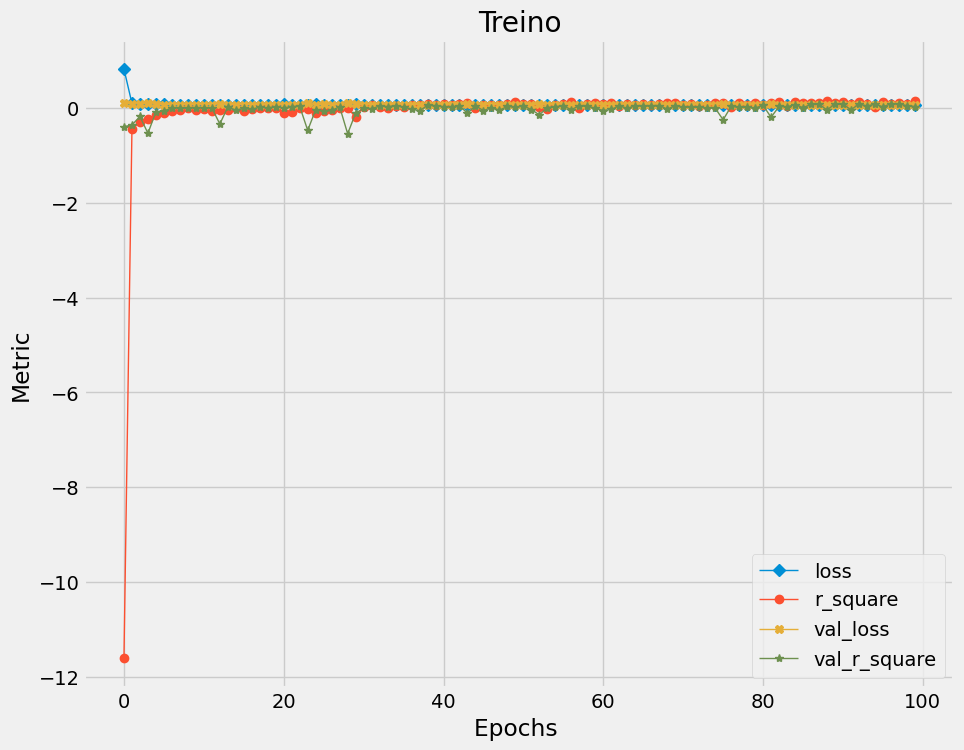

In [188]:
plot_cnn_metrics(history)

In [189]:
y_train_preds = model.predict(np.asarray(X_train)).reshape(-1)
print_evaluate(y_train, y_train_preds.astype("float16"), X_train)

20/20 [==============================] - 1s 36ms/step
MAE: 0.1826
MSE: 0.05988
RMSE: 0.2448
MAPE: 11.016845703125
R2 score: 0.08795126538610576
R2 score Ajustadoa:  -0.1283448772100746


In [190]:
y_test_preds = model.predict(np.asarray(X_test)).reshape(-1)
print_evaluate(y_test, y_test_preds.astype("float16"), X_test)

9/9 [==============================] - 0s 36ms/step
MAE: 0.1833
MSE: 0.063
RMSE: 0.251
MAPE: 11.0107421875
R2 score: 0.029638762197632507
R2 score Ajustadoa:  -0.7518602212673615


In [191]:
y_test

array([1.77 , 1.925, 1.54 , 2.246, 1.712, 1.72 , 1.712, 1.69 , 2.14 ,
       1.53 , 1.557, 1.74 , 1.77 , 1.77 , 1.54 , 1.867, 1.93 , 1.924,
       1.924, 1.458, 1.89 , 1.825, 1.98 , 2.004, 1.93 , 1.77 , 1.74 ,
       1.924, 1.474, 2.45 , 2.23 , 1.623, 2.14 , 2.055, 1.77 , 1.742,
       1.557, 1.74 , 1.604, 1.6  , 1.59 , 1.74 , 2.1  , 1.526, 1.09 ,
       1.6  , 1.82 , 1.867, 1.472, 1.496, 1.67 , 1.39 , 1.925, 1.6  ,
       1.46 , 1.742, 1.77 , 1.8  , 1.8  , 1.81 , 1.77 , 2.232, 1.969,
       1.74 , 1.695, 1.69 , 1.866, 1.604, 1.744, 2.055, 1.488, 1.595,
       1.62 , 2.055, 1.604, 1.77 , 1.8  , 1.498, 1.74 , 1.9  , 2.246,
       1.77 , 1.688, 1.48 , 1.27 , 1.74 , 1.8  , 2.246, 1.85 , 1.688,
       2.14 , 1.54 , 2.004, 1.779, 2.27 , 1.804, 1.706, 1.74 , 2.17 ,
       1.77 , 1.99 , 1.77 , 1.77 , 2.26 , 1.6  , 1.818, 1.867, 1.81 ,
       2.055, 1.717, 1.778, 1.8  , 1.635, 1.688, 1.77 , 1.81 , 1.77 ,
       1.6  , 1.523, 1.54 , 1.65 , 2.23 , 1.93 , 1.54 , 1.82 , 1.27 ,
       1.86 , 1.8  ,

In [192]:
y_test_preds.astype("float16")

array([1.828 , 2.012 , 1.716 , 1.929 , 1.791 , 1.747 , 1.817 , 1.819 ,
       2.178 , 1.735 , 1.758 , 1.789 , 1.833 , 1.8545, 1.768 , 1.973 ,
       1.904 , 1.83  , 1.883 , 1.62  , 1.691 , 1.771 , 1.814 , 1.745 ,
       2.047 , 1.831 , 1.788 , 1.797 , 1.758 , 1.866 , 1.88  , 1.758 ,
       2.291 , 2.084 , 1.994 , 1.7295, 1.7705, 1.783 , 1.735 , 2.014 ,
       1.714 , 1.789 , 1.805 , 1.779 , 1.843 , 1.922 , 1.773 , 1.854 ,
       1.7705, 1.777 , 1.837 , 1.819 , 1.926 , 1.815 , 1.716 , 1.674 ,
       1.835 , 1.743 , 1.764 , 1.738 , 1.837 , 1.799 , 1.899 , 1.781 ,
       1.722 , 1.87  , 1.859 , 1.773 , 1.768 , 2.164 , 1.757 , 1.846 ,
       1.827 , 1.896 , 1.802 , 1.776 , 1.703 , 1.71  , 1.789 , 1.966 ,
       1.884 , 1.809 , 1.826 , 1.776 , 1.869 , 1.752 , 1.792 , 1.776 ,
       1.728 , 1.811 , 1.752 , 1.736 , 1.693 , 1.886 , 1.832 , 1.774 ,
       1.787 , 1.79  , 1.836 , 2.254 , 1.782 , 1.618 , 1.844 , 1.836 ,
       1.751 , 1.754 , 2.027 , 1.7705, 2.076 , 1.804 , 1.725 , 1.707 ,
      

## EVALUATE ON SELECTED SLICE

In [193]:
valuate_result = pd.DataFrame({
    "ANILHA": anilhas_test.values,
    "PESO REAL": y_test,
    "PESO PREVISTO": y_test_preds.astype("float16"),
    "ERROR": y_test_preds.astype("float16") - y_test
})

valuate_result.head()

,ANILHA,PESO REAL,PESO PREVISTO,ERROR
0,140,1.769531,1.828125,0.058594
1,52,1.924805,2.011719,0.086914
2,1,1.540039,1.715820,0.175781
3,6,2.246094,1.928711,-0.317383
4,21,1.711914,1.791016,0.079102


In [169]:
valuate_result.ERROR.mean()

0.057253559027777796

## ERROU PARA MAIS

In [170]:
positive_error = valuate_result[valuate_result.ERROR > 0]

positive_error.head()

,ANILHA,PESO REAL,PESO PREVISTO,ERROR
0,140,1.770,1.828125,0.058125
1,52,1.925,2.011719,0.086719
2,1,1.540,1.715820,0.175820
4,21,1.712,1.791016,0.079016
5,154,1.720,1.747070,0.027070


In [171]:
positive_error.ERROR.mean()

0.18048862847222222

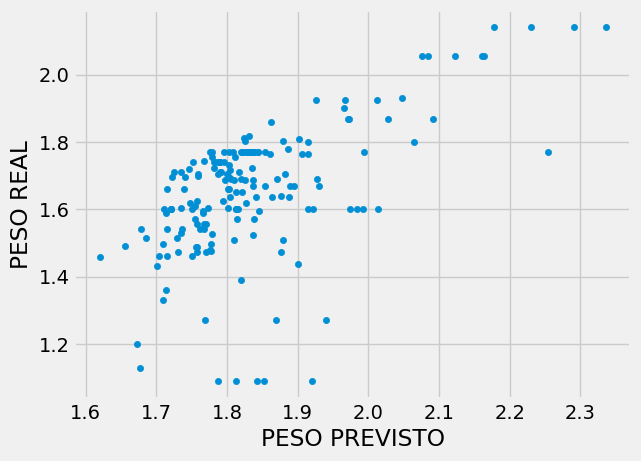

In [172]:
positive_error.plot.scatter(
    x="PESO PREVISTO", 
    y="PESO REAL",
);

### Há quntos errados para mais ?

In [173]:
len(positive_error)

180

### QUAIS SÃO AS GALINHAS MAIS DISTANTES DO PESO REAL ?

<AxesSubplot:>

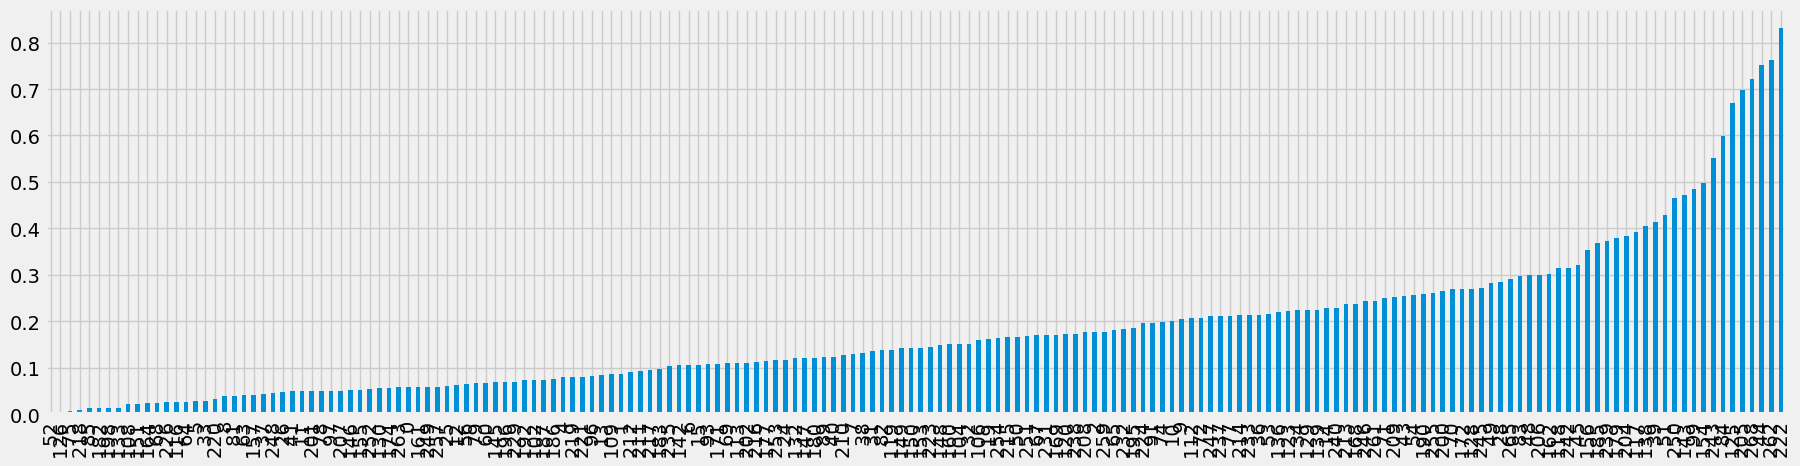

In [174]:
plt.figure(figsize = (20, 5))
(positive_error.ERROR).sort_values().plot.bar(x="ANILHA", y="ERROR")

In [180]:
positive_error[positive_error.ERROR > 0.25].ANILHA.value_counts()

90     6
2      5
40     3
55     2
161    2
157    1
127    1
159    1
4      1
45     1
57     1
64     1
33     1
71     1
16     1
133    1
80     1
110    1
105    1
43     1
9      1
145    1
39     1
124    1
91     1
147    1
117    1
41     1
68     1
Name: ANILHA, dtype: int64

### ERROU PARA MENOS

In [181]:
negative_error = valuate_result[valuate_result.ERROR < 0]

negative_error.head()

,ANILHA,PESO REAL,PESO PREVISTO,ERROR
3,6,2.247,1.928711,-0.318289
16,36,1.930,1.904297,-0.025703
17,126,1.924,1.830078,-0.093922
18,5,1.924,1.882812,-0.041187
20,151,1.890,1.691406,-0.198594


### Há quntos errados para menos ?

In [182]:
len(negative_error)

90

### QUAIS SÃO AS GALINHAS MAIS DISTANTES DO PESO REAL ?

<AxesSubplot:>

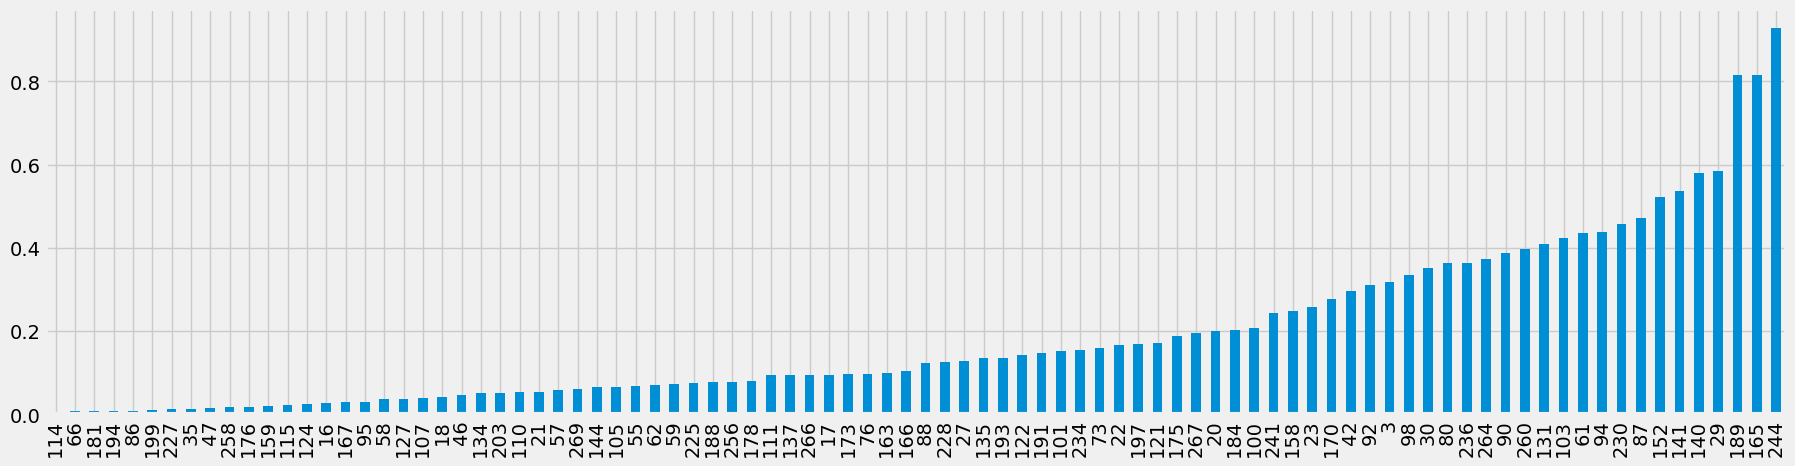

In [183]:
plt.figure(figsize = (20, 5))
(negative_error.ERROR * -1).sort_values().plot.bar(x="ANILHA", y="ERROR")

In [185]:
negative_error[negative_error.ERROR < -0.25].ANILHA.value_counts()

6      4
121    3
34     2
153    2
30     2
53     2
89     2
155    2
129    1
19     1
93     1
120    1
47     1
102    1
Name: ANILHA, dtype: int64